# Nonparametric Regression

Nonparametric regression is a statistical method used to model the relationship between variables without making explicit assumptions about the functional form of the underlying relationship. Unlike parametric regression models that assume a specific functional form (such as linear, quadratic, or exponential), nonparametric regression allows for more flexibility and adaptability in capturing complex patterns in the data. Nonparametric regression is particularly useful when dealing with data where the underlying relationship is not well understood or when there is a need for flexibility in modeling complex patterns without making strong assumptions about the functional form.

A sample $(X_i,Y_i)_{i=1,\dots,n}$ of indenpendent and identically distributed observations is given. The regression function $f$ is defined by the conditional expectation as

$$ f(x) := \mathbb{E}[Y_i | X_i = x] $$ 

or equivalent

$$ Y_i = f(x_i) + \epsilon_i \qquad i = 1, \dots , n $$

with i.i.d $(\epsilon_i)_{i=1,\dots, n} $ and $\mathbb{E}[\epsilon_i]=0$ 

In nonparametric regression, the goal is to estimate the conditional expectation of the response variable given the values of one or more predictor variables. This is done without specifying a predefined equation for the relationship. Instead, nonparametric methods rely on the data itself to determine the shape of the relationship. Hereby we call $Y_i$ the response variable and $X_i$ the covariables. If there is no finite-dimensional parametrization of $f$ we consider a nonparametric regression.



Firstly, we want to sample some random data points which are given by random variables $X$ and $Y$.

In this example we assume the covariance random variables $X$ to be uniformly distributed and the response random variables $Y$ according to function $f$

$$ f(x) = 5 * \sin(\frac{4 \pi}{x+1}) $$

Furthermore we assume the noise $(\epsilon_i)_{i=1,\dots,n} \sim \mathcal{N}(0,1)$.

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

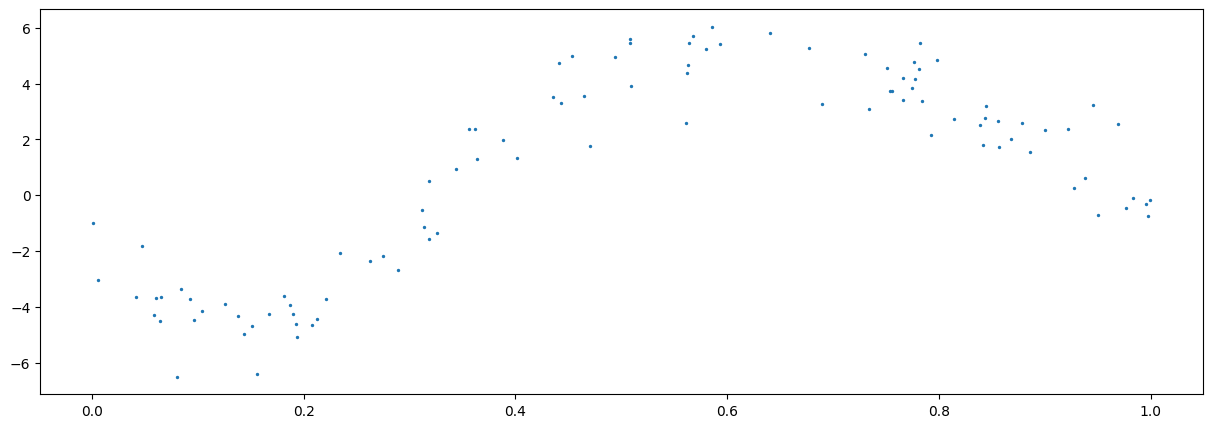

In [3]:
Number_samples = 100
x_min = -10
x_max = 10

# Define the Regressionfunction
def f(x):
    return 5 * np.sin((4*np.pi)/(x+1))

X = np.random.uniform(0,1,size=Number_samples)
Y = f(X) + np.random.normal(0,1,size=Number_samples)

plt.figure(figsize=(15,5))
plt.scatter(X,Y, s=2) 

### Kernel functions

Nonparametric regression often involves estimating the relationship between variables in local neighborhoods of the data rather than across the entire dataset. Local methods, such as kernel regression or local polynomial regression, focus on small regions of the predictor space and adapt to the data within those regions. Thus, we firstly implement some of the standard kernel functions.

* Window-Estimator: $K_h(x) = h^{-d} \mathbb{1}_{[-h/2,h/2]^d}(x) $
* Triangular-Estimator: $K_h(x)=h^{-d} \mathbb{1}_{[-h/2,h/2]^d}(1-|x|) $
* Epa-Estimator: $K_h(x)=\frac{3}{4h^{d}}\mathbb{1}_{[-h,h]^{d}}(1-x^{2}) $
* Gauss-Estimator: $K(x) = (2\pi)^{-d/2} e^{-|x|^{2}/2} $
* Sinc-Estimator: $K(x) = \pi^{-d} \prod_{i=1}^{d}\frac{\sin(x_i)}{x_i} $


In many nonparametric methods, the bandwidth or window parameter plays a crucial role. It determines the size of the local neighborhood around each data point that is considered when estimating the relationship. The choice of bandwidth influences the trade-off between bias and variance in the estimation. Therefore, the bandwidth $h$ is given as an input parameter and the differente kernels are plotted with differente bandwidth values.

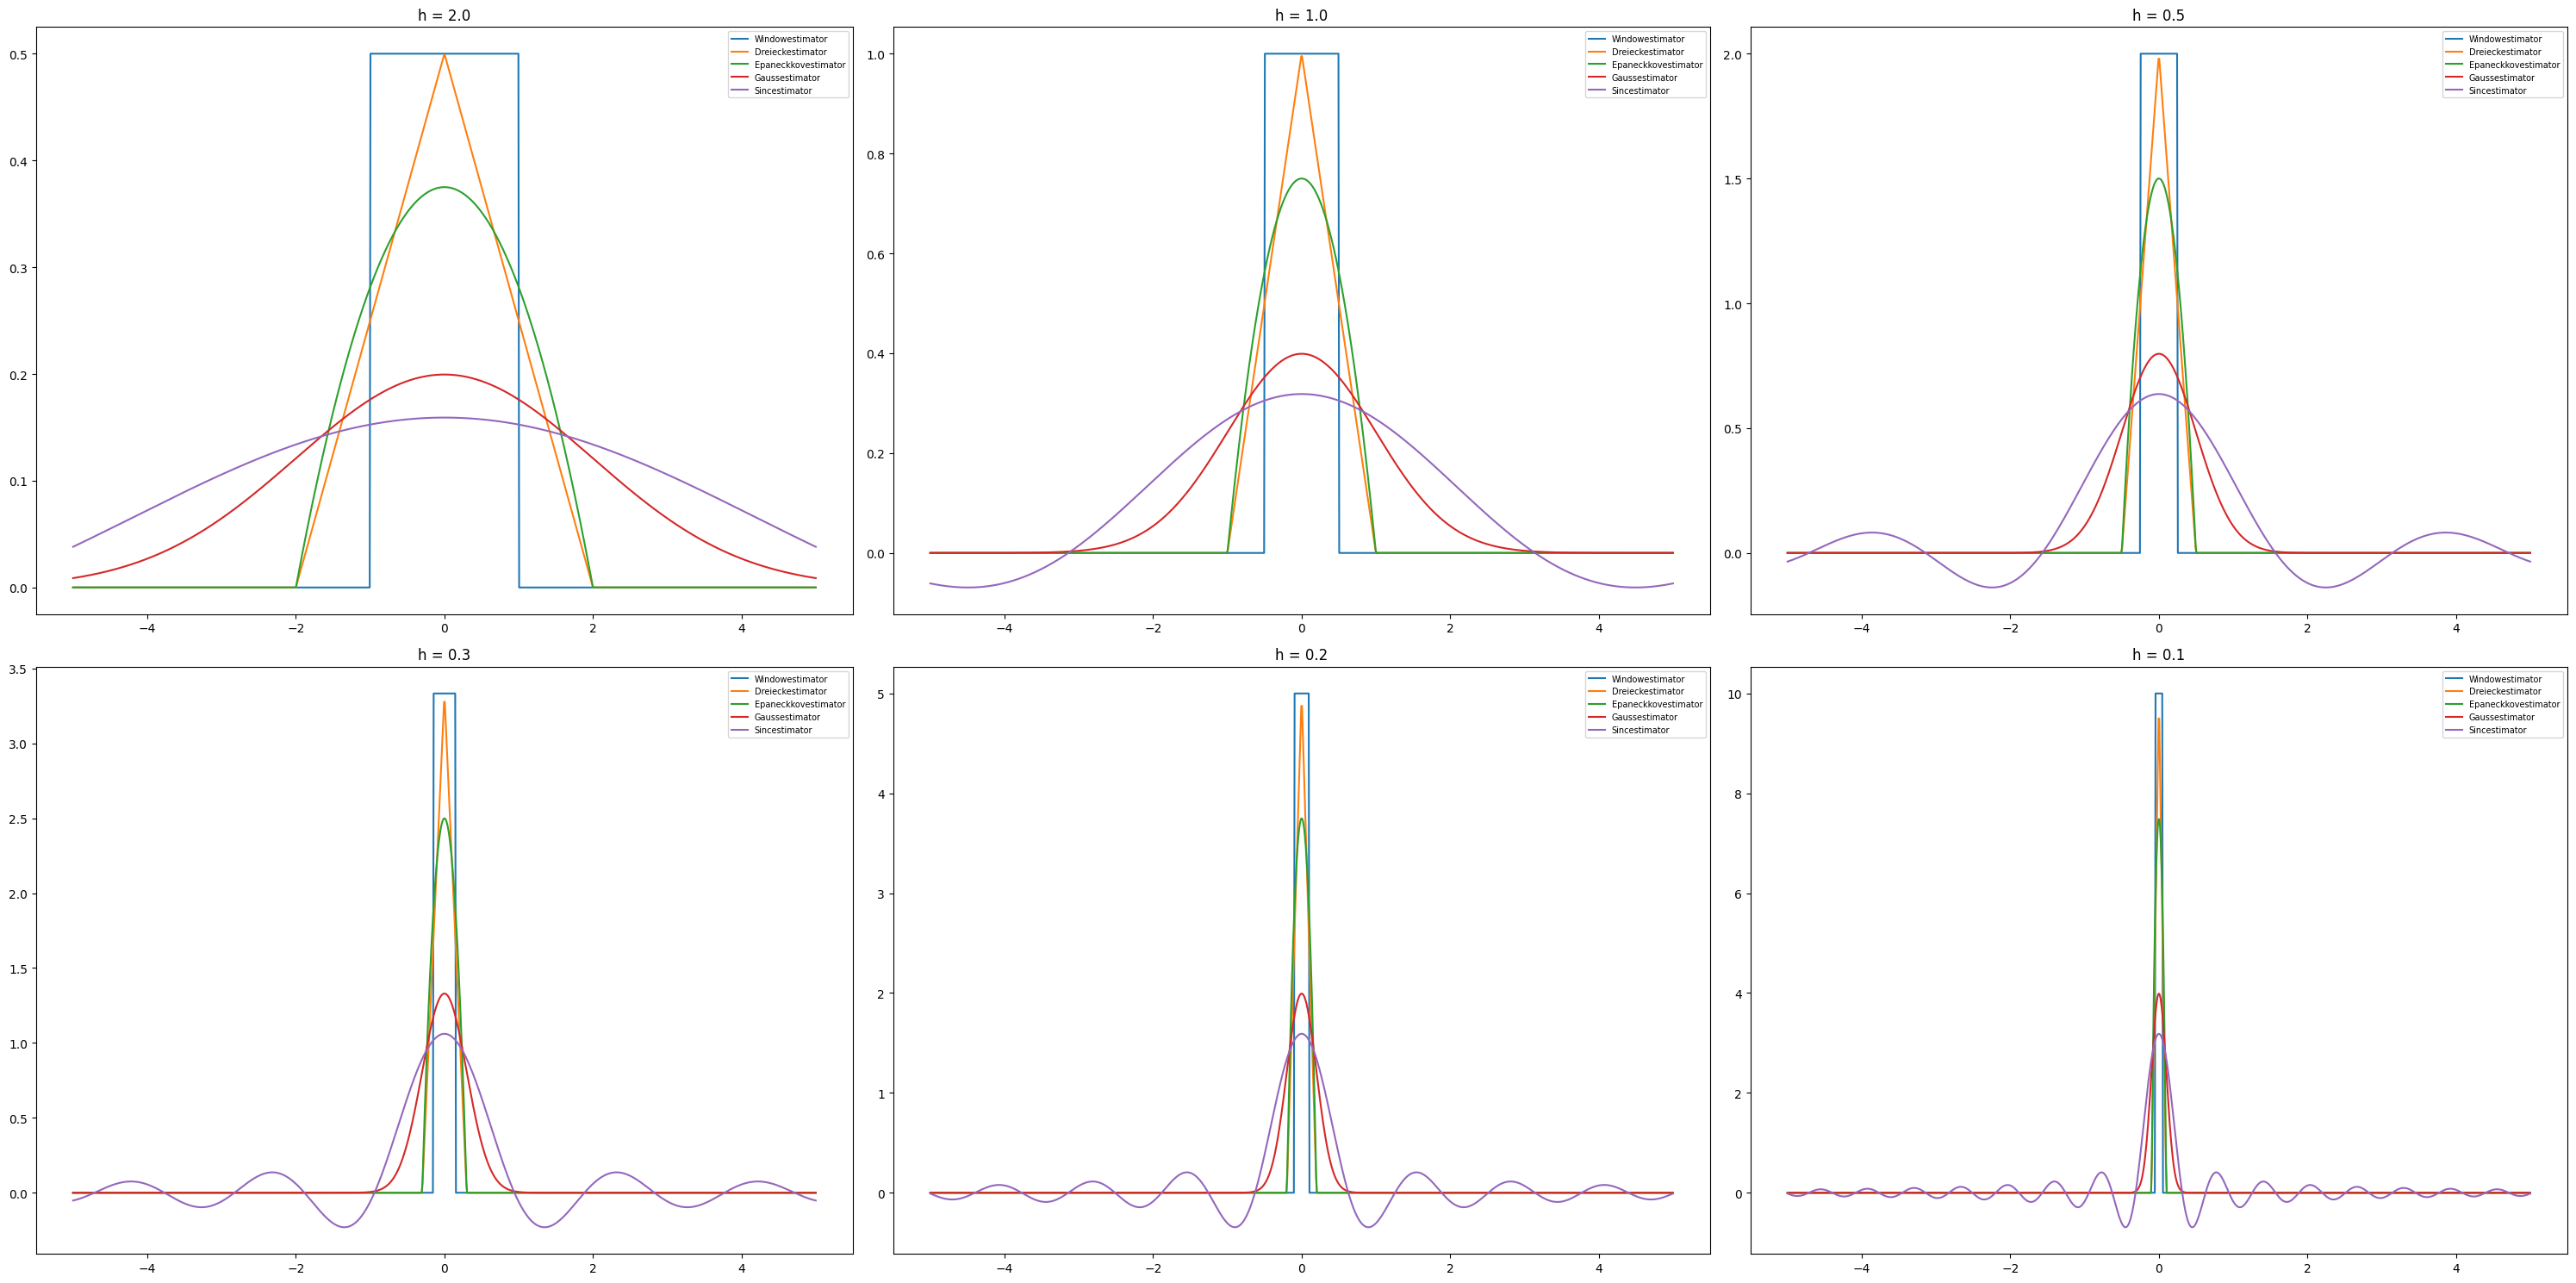

In [9]:
def K_Fenster(x,h):
    return 1/h * np.where(np.logical_and(x/h >= -0.5, x/h <= 0.5), 1, 0)

def K_Dreieck(x,h):
    return 1/h * np.where(np.logical_and(x/h > - 1, x/h < 1), 1 - np.abs(x/h), 0)

def K_Epa(x,h):
    return 1/h * np.where(np.logical_and(x/h > -1, x/h < 1), (3/4)*(1-(x/h)**2),0)

def K_Gauß(x,h):
    return 1/h * (2*np.pi)**(-0.5)*np.exp(-0.5 * np.abs(x/h)**2)

def K_sinc(x,h):
    return 1/(h*np.pi) * (np.sin(x/h)/(x/h))


h = np.array([2, 1, 0.5, 0.3, 0.2, 0.1])
x = np.linspace(-5,5, 1000)

plt.figure(figsize=(30,15), layout = 'tight')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(x, K_Fenster(x,h[i]), label = 'Windowestimator')
    plt.plot(x,K_Dreieck(x,h[i]), label = 'Dreieckestimator')
    plt.plot(x, K_Epa(x,h[i]), label = 'Epaneckkovestimator')
    plt.plot(x, K_Gauß(x,h[i]), label = 'Gaussestimator')
    plt.plot(x, K_sinc(x,h[i]), label = 'Sincestimator')
    plt.title(f"h = {h[i]}")
    plt.legend(fontsize = 7)


## Local polynomial Estimator

### Nadaraya-Watson Estimator

The Nadaraya-Watson estimator is a kernel regression method, and it falls under the broader category of local polynomial regression. It uses a kernel function to give more weight to data points that are closer to the point of interest.

The Nadaraya-Watson estimator $NWE$ is given by

$$ \hat{f_{nh}^{NW}}(x) = \frac{\sum_{i=1}^{n}K_{h}(x-x_{i})y_{i}}{\sum_{i=1}^{n}K_{h}(x-x_{i})} $$

It is well defined for 

$$ x \in D \qquad \sum_{i=1}^{n}K_h(x-x_i) \neq 0 $$

**Advantages**:

* The Nadaraya-Watson estimator is relatively simple and computationally
efficient.
* It is a flexible tool for capturing local patterns in the data without assuming a specific functional form for the underlying relationship.

**Considerations**:
* The choice of the bandwidth parameter is crucial. Cross-validation or other methods may be used to determine an optimal bandwidth.
* The performance of the Nadaraya-Watson estimator can be sensitive to outliers.

C:\Users\simon\AppData\Local\Temp\ipykernel_3128\3791353751.py:14: RuntimeWarning: invalid value encountered in divide
  return 1/(h*np.pi) * (np.sin(x/h)/(x/h))


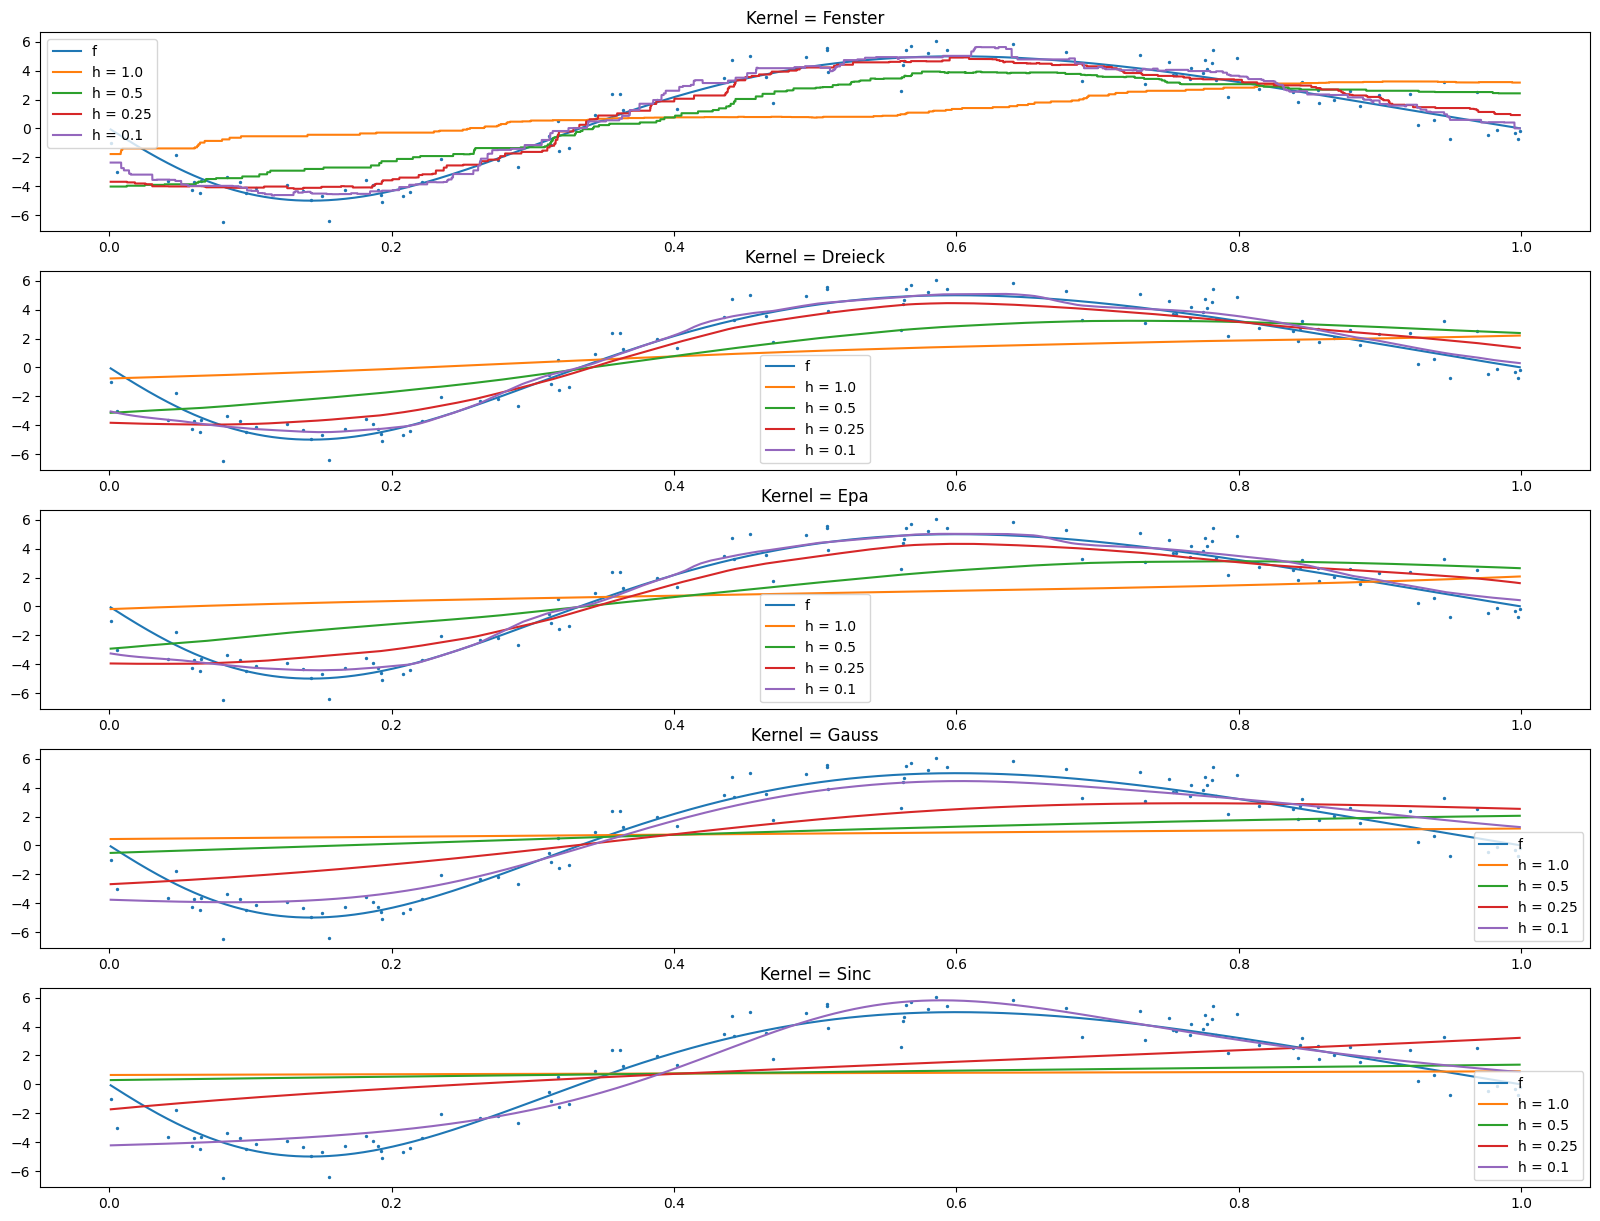

In [5]:
def NWE(x,h, X, Y, kernel_type = 'Fenster'):
   """This function is the Nadaraya-Watson Estimator

   Args:
       x (float): Values for which the estimator is evaluated
       h (_type_): The bandwidth
       X (float): Given X samples
       Y (float): Given Y = f(X) + noise
       kernel_type (str, optional): Type of kernel. Defaults to 'Fenster'. Choose from 'Fenster', 'Dreieck', 'Epa', 'Gauss'  or 'Sinc'

   Raises:
       ValueError: Invalid kernel type

   Returns:
       (float): Evaluation of x of the estimator
   """
   nominator = 0
   denominator = 0
   for i in range(len(X)):
      if kernel_type == 'Fenster':
         nominator += Y[i] * K_Fenster(x - X[i],h) 
         denominator += K_Fenster(x - X[i],h)
      elif kernel_type == 'Dreieck':
         nominator += Y[i] * K_Dreieck(x - X[i],h) 
         denominator += K_Dreieck(x - X[i],h)
      elif kernel_type == 'Epa':
         nominator += Y[i] * K_Epa(x - X[i],h) 
         denominator += K_Epa(x - X[i],h)
      elif kernel_type == 'Gauss':
         nominator += Y[i] * K_Gauß(x - X[i],h) 
         denominator += K_Gauß(x - X[i],h)
      elif kernel_type == 'Sinc':
         nominator += Y[i] * K_sinc(x - X[i],h) 
         denominator += K_sinc(x - X[i],h)
      else:
         raise ValueError("Invalid kernel type. Choose from 'Fenster', 'Dreieck', 'Epa', 'Gauss'  or 'Sinc'.")

   return nominator/denominator

# Define bandwith
h = np.array([1,0.5,0.25,0.1])
kernel = ['Fenster', 'Dreieck', 'Epa', 'Gauss', 'Sinc']
plt.figure(figsize=(20,15))

# Define the grid 
x_pred = np.linspace(min(X),max(X),Number_samples*100)

for i in range(len(kernel)):
    plt.subplot(len(kernel),1,i+1)
    plt.scatter(X,Y, s=2)
    plt.plot(x_pred, f(x_pred), label= 'f')
    for j in range(len(h)):
        plt.plot(x_pred,NWE(x_pred,h[j],X,Y,kernel_type= kernel[i]), label = f"h = {h[j]}")
    plt.title(f"Kernel = {kernel[i]}")
    plt.legend()

### Local-linear Estimator

The local linear estimator is a nonparametric regression technique that extends the idea of local smoothing to include fitting local linear functions to the data. It is designed to provide a more flexible and accurate estimation of the underlying relationship between variables compared to simpler local methods like the Nadaraya-Watson estimator. The local linear estimator is particularly useful when the relationship between variables exhibits curvature or changing slopes. It involves fitting a linear function within a local neighborhood. 

The local-linear estimator $LLE$ is given by

$$ \hat{f}_{n,h}^{LPm}(x) = \sum_{i=1}^{n} Y_i w_i(x) $$

with local weights given by

$$ w_i(x) := n^{-1} (B_h(x)^{-1}- P(\frac{X_i - x}{h})_{1} K_h(x-X_i)) $$

Similar to other local methods, the local linear estimator assigns weights to data points based on their distance from the point of interest. The weighting function emphasizes nearby points and downweights those further away.

For the Window-estimator the local weights are given as

$$ w_i(x) = \frac{1}{d(x)} \biggl(\sum_{j\in I_h(x)}  (X_j - x)^{2} - \sum_{j \in I_h(x)} (X_j - x)(X_i - x) \mathbb{1}_{i \in I_h(x)} \biggl)$$

with 

$$ d(x) := \biggl( \sum_{i\in I_h(x)} (X_i - x )^{2}\biggl) \biggl( \sum_{i\in I_h(x)} 1 \biggl) - \biggl( \sum_{i \in I_h(x)} (X_i - x)  \biggl)^2 $$

The bandwidth parameter $h$ determines the size of the local neighborhood over which the linear function is fit. As with other local methods, the choice of bandwidth is crucial and affects the trade-off between bias and variance in the estimation.

**Advantages**:
* The local linear estimator provides a more flexible model by fitting a local linear function, allowing it to capture changing slopes and curvature in the data.
* It tends to perform well in regions where the underlying relationship is approximately linear.

**Considerations**:
* The local linear estimator is more computationally intensive than simpler local methods, but it can be efficient with modern computational resources.
* The choice of bandwidth is critical, and cross-validation or other methods may be used to select an optimal bandwidth.

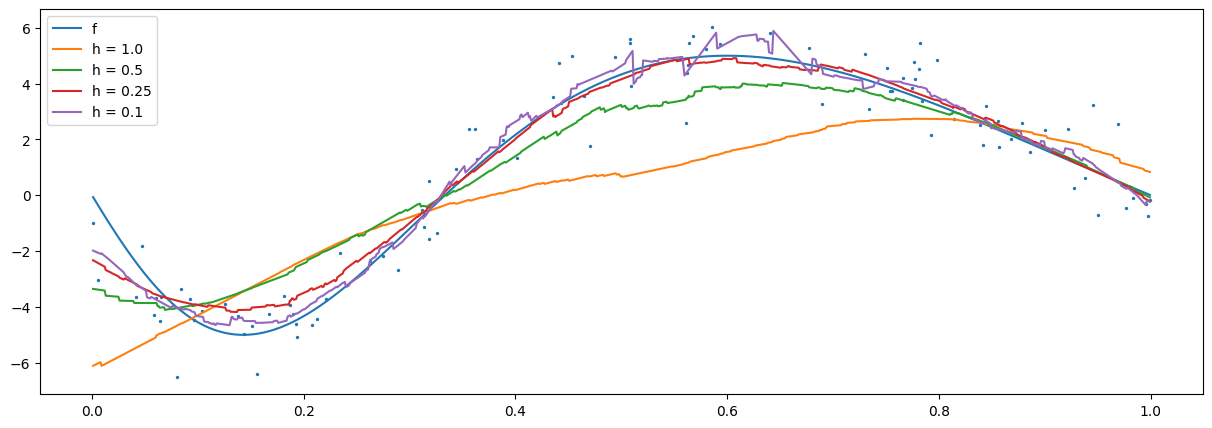

In [6]:
def weight_i_loclin_estimator(x,X,i,h):
    """This function evaluates the local weights given a index i

    Args:
        x (float): Values for which the weights are evaluated
        X (float): Given X samples
        i (int): index i
        h (float): The bandwidth

    Returns:
        (float): The weights
    """
    if abs(X[i] - x) > h/2:
        return 0
    else:
        number_in_Ih = 0
        diff_squared = 0
        diff = 0
        covariance_sum = 0
        #d = d_loclin_estimator(x,X)
        for entry in X:
            if abs(entry-x)<= h/2:
                number_in_Ih = number_in_Ih + 1
                diff_squared = diff_squared + (entry - x)**2
                diff = diff + (entry - x)
                covariance_sum = covariance_sum + (entry - x)*(X[i] - x)
    return (1/((diff_squared*number_in_Ih - diff**2))) * (diff_squared - covariance_sum)
 
 

def LLE(x, h , X , Y):
    """This functions evaluates the local-linear estimator

    Args:
        x (float): Values for which the weights are evaluated
        h (float): The bandwidth
        X (float): Given samples X
        Y (float): Given Y = f(X) + noise 

    Returns:
        (float): The evaluated estimator
    """
    result = []
    for xi in x:
        sum = 0
        for i in range(len(Y)):
            sum = sum + Y[i]*weight_i_loclin_estimator(xi, X, i, h)
        result.append(sum)
    return result

# Define bandwith
h = np.array([1,0.5,0.25,0.1])
plt.figure(figsize=(15,5))

# Define the grid 
x_pred = np.linspace(min(X),max(X),Number_samples*10)

# Visualize
plt.scatter(X,Y, s=2)
plt.plot(x_pred, f(x_pred), label= 'f')
for j in range(len(h)):
    plt.plot(x_pred,LLE(x_pred,h[j],X,Y), label = f"h = {h[j]}")
plt.legend()

Furthermore we want to look at the bias and the variance of each estimator

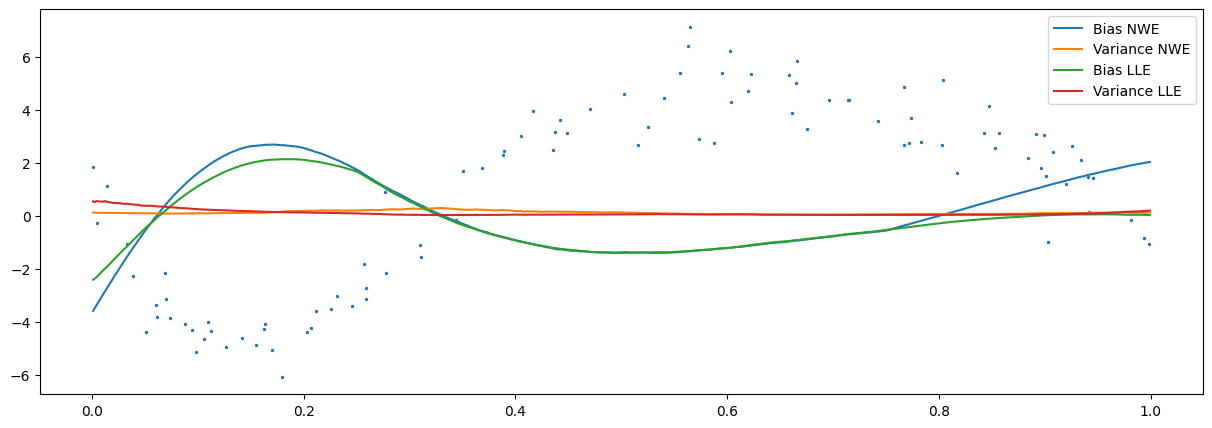

In [8]:
h = np.array([0.5])

# bias & variance
y_correct = f(x_pred)

N = 100

nwe_est = np.zeros([N,len(x_pred)])
lle_est = np.zeros([N,len(x_pred)])

for i in range(0, N):
    X = np.random.uniform(0,1,size=Number_samples)
    Y = f(X) + np.random.normal(0,1,size=Number_samples)
    nwe_est[i,:] = NWE(x_pred,h=h[0],X=X, Y=Y)
    lle_est[i,:] = LLE(x_pred,h=h[0],X=X,Y=Y)
    
bias_nwe = np.zeros(len(x_pred))
var_nwe = np.zeros(len(x_pred))
bias_lle = np.zeros(len(x_pred))
var_lle = np.zeros(len(x_pred))

for i in range(0, len(x_pred)):
    bias_nwe[i] = np.mean(nwe_est[:,i]) - y_correct[i]
    var_nwe[i] = np.var(nwe_est[:,i], ddof=1)
    
    bias_lle[i] = np.mean(lle_est[:,i]) - y_correct[i]
    var_lle[i] = np.var(lle_est[:,i], ddof=1)

    
plt.figure(figsize=(15,5))
plt.plot(x_pred, bias_nwe, label='Bias NWE')
plt.plot(x_pred, var_nwe, label='Variance NWE')
plt.plot(x_pred, bias_lle, label='Bias LLE')
plt.plot(x_pred, var_lle, label='Variance LLE')
plt.scatter(X,Y, s=2)
plt.legend()